**TBATS**: periodo di 2 anni più tre mesi 2022, osservazioni trimestrali, due stagionalità: settimanale e annuale

**T**rigonometric seasonality, **B**ox-Cox transformation, **A**RMA errors, **T**rend and **S**easonal components.

![tbats](https://miro.medium.com/max/1050/1*yfruZnSYsNt1X1uyag46eQ.png)

Each seasonality is modeled by a trigonometric representation based on Fourier series. One major advantage of this approach is that it requires only 2 seed states regardless of the length of period. Another advantage is the ability to model seasonal effects of non-integer lengths. For example, given a series of daily observations, one can model leap years with a season of length 365.25.

**BATS** differs from TBATS only in the way it models seasonal effects. In BATS we have a more traditional approach where each seasonality is modeled by:

![bats](https://miro.medium.com/max/1050/1*D8KY2jQRmVRLHY5f4RNqKA.png)

This implies that BATS can only model integer period lengths. Approach taken in BATS requires m_i seed states for season i, if this season is long the model may become intractable.

How Does TBATS Choose The Final Model

Under the hood TBATS will consider various alternatives and fit quite a few models. It will consider models:
- with Box-Cox transformation and without it.
- with and without Trend
- with and without Trend Damping
- with and without ARMA(p,q) process used to model residuals
- non-seasonal model
- various amounts of harmonics used to model seasonal effects

The final model will be chosen using Akaike information criterion (AIC).

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tbats import BATS, TBATS

In [3]:
df = pd.read_csv('../data/pesca_mensile.csv')
df.head()

,Datetime,totale
0,2014-01-31,3188.02
1,2014-02-28,96599.77
2,2014-03-31,182915.30
3,2014-04-30,106539.32
4,2014-05-31,127715.16


In [4]:
df = df.rename(columns={"Datetime": "data"})
df['data'] = pd.to_datetime(df['data'])

In [5]:
df.dtypes

data      datetime64[ns]
totale           float64
dtype: object

In [6]:
df.head()

,data,totale
0,2014-01-31,3188.02
1,2014-02-28,96599.77
2,2014-03-31,182915.30
3,2014-04-30,106539.32
4,2014-05-31,127715.16


In [7]:
mask = (df['data'] < '2022-01-01')

In [8]:
df = df.loc[mask]

In [9]:
df

,data,totale
0,2014-01-31,3188.02
1,2014-02-28,96599.77
2,2014-03-31,182915.30
3,2014-04-30,106539.32
4,2014-05-31,127715.16
...,...,...
91,2021-08-31,587279.98
92,2021-09-30,519864.41
93,2021-10-31,576174.03
94,2021-11-30,709360.12


In [10]:
df = df.set_index('data')
df.head()

,totale
data,
2014-01-31,3188.02
2014-02-28,96599.77
2014-03-31,182915.30
2014-04-30,106539.32
2014-05-31,127715.16


In [11]:
df = df[['totale']]
df.head()

,totale
data,
2014-01-31,3188.02
2014-02-28,96599.77
2014-03-31,182915.30
2014-04-30,106539.32
2014-05-31,127715.16


In [12]:
y = df['totale']

In [13]:
len(y)

96

In [14]:
len(y) / 100 * 20

19.2

In [15]:
steps = 19

y_to_train = y.iloc[:(len(y)-steps)]
y_to_test = y.iloc[(len(y)-steps):] # last year for testing

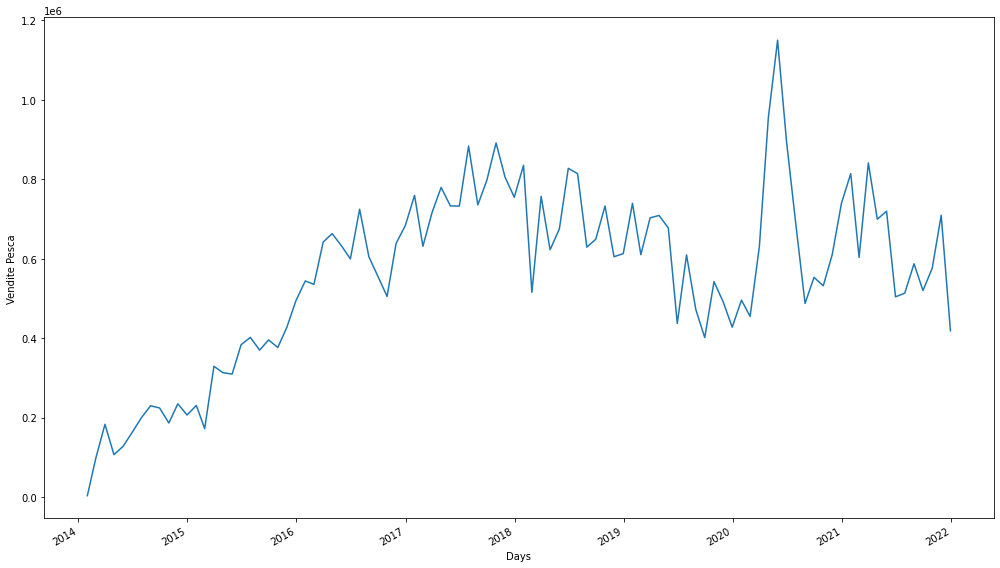

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['totale'])
ax.set_xlabel('Days')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

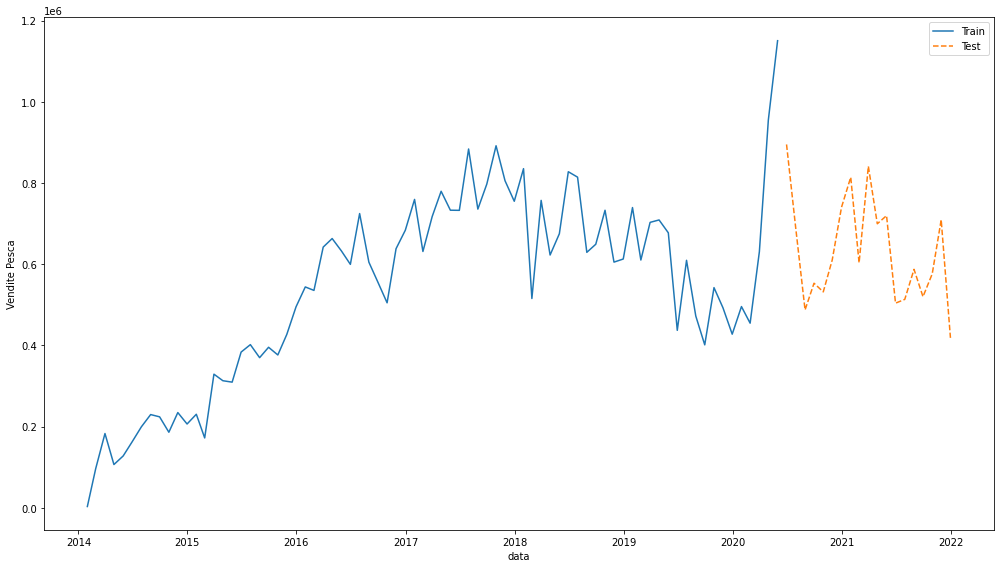

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite Pesca')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

Da questa figura dovremmo individuare pattern di stagionalità. (Ad esempio settimanale, mensile, annuale, ecc.)

Before we implement our more complex BATS and TBATS models, it’s always a good idea to have a baseline model. That way, we can determine if our more complex forecasting methods are actually performant.

In [18]:
y_pred_baseline = y_to_train[-steps:].values

In [19]:
# Fit the model
estimator = TBATS()
model = estimator.fit(y_to_train)

# Forecast 365 days ahead
y_forecast = model.forecast(steps)

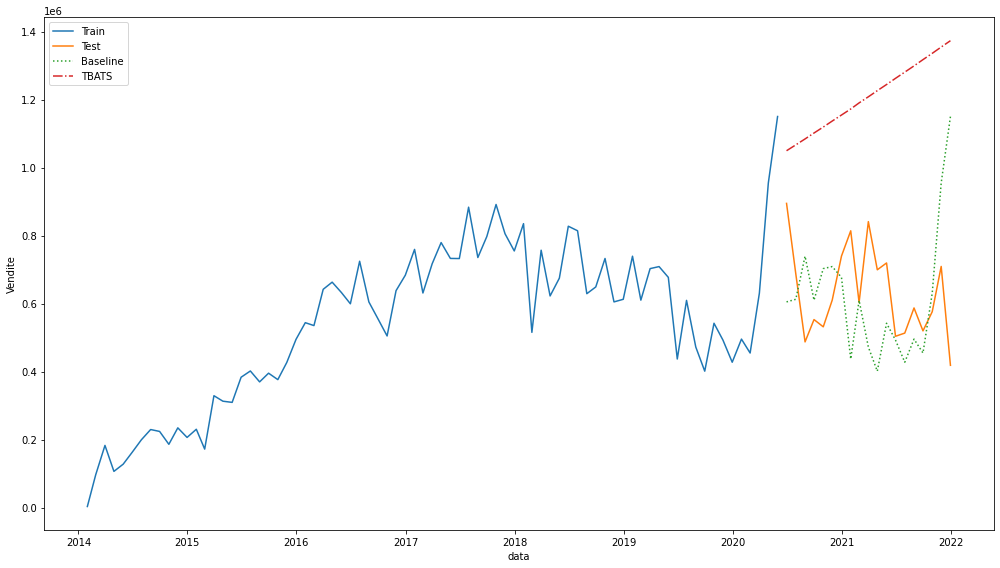

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='-', label='Test')
ax.plot(y_to_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_to_test.index, y_forecast, ls='-.', label='TBATS')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

MAPE

In [21]:
print('Did the model fit?', model.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', model.aic)  # may be np.inf

Did the model fit? True
AIC 2111.728368820762


In [22]:
# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(model.summary())



SUMMARY FUNCTION


Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.705099
Smoothing (Alpha): 0.634963
Trend (Beta): -0.006386
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [4088.41354351  283.67332337]

AIC 2111.728369


In [23]:
print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', model.y[:5])
print('Predictions (5 first values)', model.y_hat[:5])
print('Residuals (5 first values)', model.resid[:5])



IN SAMPLE PREDICTIONS


Original time series (5 first values) [  3188.02  96599.77 182915.3  106539.32 127715.16]
Predictions (5 first values) [ 88788.61837404  32891.21589573  79144.26054382 151256.69211863
 131322.62738099]
Residuals (5 first values) [-85600.59837404  63708.55410427 103771.03945618 -44717.37211863
  -3607.46738099]


In [24]:
steps = steps # one year in this case
y_forecasted = model.forecast(steps=steps)

In [25]:
print('\n\nFORECAST\n\n')
print('Values', y_forecasted)
print('MAE', np.mean(np.abs(y_forecasted - y_to_test)))



FORECAST


Values [1049713.4048198  1067013.30093667 1084396.31353326 1101861.89345165
 1119409.50128855 1137038.60711566 1154748.69021091 1172539.23880035
 1190409.74980977 1208359.72862594 1226388.68886674 1244496.15215993
 1262681.64793006 1280944.71319316 1299284.89235886 1317701.7370396
 1336194.80586658 1354763.66431222 1373407.88451873]
MAE 577399.697623076


In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_forecasted), np.array(y_to_test)
    return np.mean(np.abs((y_forecasted - y_to_test) / y_forecasted)) * 100

In [27]:
print('MAPE', mean_absolute_percentage_error(y_forecasted, y_to_test))

MAPE 47.09300078778119
